In [46]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from datetime import datetime, date, time

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)

df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-03-20 11:04:00,1,0,0,2,2,15,0,8,...,0,0,2,0,0,0,0,0,0,0
2,1,2024-03-20 11:05:00,1,0,0,5,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2024-03-20 11:06:00,1,0,0,3,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2024-03-20 11:07:00,1,0,0,0,1,3,0,0,...,1,0,1,0,0,0,0,0,0,0
5,1,2024-03-20 11:08:00,1,0,0,0,1,4,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10040,8,2024-03-27 10:23:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10041,8,2024-03-27 10:24:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10042,8,2024-03-27 10:25:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
import pandas as pd
from scipy.stats import ttest_1samp

# Assuming your data is in a DataFrame 'df' with columns 'spider_id', 'day', 'activity_counts', 'light_transition_time'

# Step 1: Identify activity onset
activity_onsets = []
for spider_id, spider_data in df.groupby('spider_id'):
    for day, day_data in spider_data.groupby('day'):
        # Find the time when activity count crosses a threshold (e.g., 10)
        onset_time = day_data[day_data['activity_counts'] > 10].index[0]
        activity_onsets.append({'spider_id': spider_id, 'day': day, 'onset_time': onset_time})

activity_onsets_df = pd.DataFrame(activity_onsets)

# Step 2: Calculate anticipation
activity_onsets_df['anticipation'] = activity_onsets_df['onset_time'] - df[['spider_id', 'day', 'light_transition_time']].set_index(['spider_id', 'day'])['light_transition_time']

# Step 3: Test for significance
anticipation_values = activity_onsets_df.groupby('spider_id')['anticipation'].apply(lambda x: x.values)

for spider_id, anticipations in anticipation_values.items():
    t_stat, p_val = ttest_1samp(anticipations, 0)
    if p_val < 0.05:
        print(f"Spider {spider_id} is entrained (p-value = {p_val:.4f})")
    else:
        print(f"Spider {spider_id} is not entrained (p-value = {p_val:.4f})")

KeyError: 'spider_id'

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming your DataFrame is named 'df'
# First, let's melt the DataFrame to make it easier to work with
df_melted = df.melt(id_vars=['Day', 'Time', 'Light'], 
                    var_name='Spider', 
                    value_name='Activity')

# Convert 'Time' to datetime if it's not already
df_melted['Time'] = pd.to_datetime(df_melted['Time'])

# Function to find activity onset
def find_onset(group, threshold=10):
    # Find the first time activity exceeds the threshold
    onset = group[group['Activity'] > threshold]['Time'].min()
    return onset if pd.notnull(onset) else None

# Function to find light transition
def find_light_transition(group):
    # Find the time when light changes from 0 to 1 or 1 to 0
    transition = group[group['Light'] != group['Light'].shift()]['Time'].min()
    return transition if pd.notnull(transition) else None

# Group by Day and Spider, then find onset for each group
onsets = df_melted.groupby(['Day', 'Spider']).apply(find_onset).reset_index()
onsets.columns = ['Day', 'Spider', 'Onset']

# Find light transitions for each day
light_transitions = df_melted.groupby('Day').apply(find_light_transition).reset_index()
light_transitions.columns = ['Day', 'LightTransition']

# Merge onsets and light transitions
results = pd.merge(onsets, light_transitions, on='Day')

# Calculate anticipation (in minutes)
results['Anticipation'] = (results['Onset'] - results['LightTransition']).dt.total_seconds() / 60

# Perform t-test for each spider
for spider in results['Spider'].unique():
    spider_data = results[results['Spider'] == spider]['Anticipation']
    if len(spider_data) > 1 and spider_data.std() > 0:  # Check for at least 2 values and non-zero variance
        t_stat, p_val = ttest_1samp(spider_data, 0)
        if p_val < 0.05:
            print(f"{spider} is entrained (p-value = {p_val:.4f})")
        else:
            print(f"{spider} is not entrained (p-value = {p_val:.4f})")
    else:
        print(f"Not enough data or no variance for {spider}")

display(df_melted)

Not enough data or no variance for Sp1
Not enough data or no variance for Sp10
Not enough data or no variance for Sp11
Not enough data or no variance for Sp12
Sp13 is not entrained (p-value = nan)
Sp14 is not entrained (p-value = nan)
Not enough data or no variance for Sp15
Sp16 is not entrained (p-value = nan)
Not enough data or no variance for Sp17
Sp18 is not entrained (p-value = nan)
Sp19 is not entrained (p-value = nan)
Not enough data or no variance for Sp2
Not enough data or no variance for Sp20
Sp21 is entrained (p-value = 0.0086)
Sp22 is entrained (p-value = 0.0032)
Not enough data or no variance for Sp23
Not enough data or no variance for Sp24
Sp25 is not entrained (p-value = nan)
Not enough data or no variance for Sp26
Not enough data or no variance for Sp27
Not enough data or no variance for Sp28
Not enough data or no variance for Sp29
Sp3 is not entrained (p-value = nan)
Not enough data or no variance for Sp30
Not enough data or no variance for Sp31
Not enough data or no v

,Day,Time,Light,Spider,Activity
0,1,2024-03-20 11:04:00,1,Sp1,0
1,1,2024-03-20 11:05:00,1,Sp1,0
2,1,2024-03-20 11:06:00,1,Sp1,0
3,1,2024-03-20 11:07:00,1,Sp1,0
4,1,2024-03-20 11:08:00,1,Sp1,0
...,...,...,...,...,...
321403,8,2024-03-27 10:23:00,1,Sp32,0
321404,8,2024-03-27 10:24:00,1,Sp32,0
321405,8,2024-03-27 10:25:00,1,Sp32,0
321406,8,2024-03-27 10:26:00,1,Sp32,0


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

df = dataframes['df1']
df['Time'] = pd.to_datetime(df['Time'])
light_column = df['Light']
difference = np.diff(light_column)
df['Light2'] = np.append(difference, np.nan)

def find_activity_onset(activity_data, light_off_time, window_size=60, threshold=2):
    post_light_off = activity_data[activity_data.index > light_off_time].iloc[:180]
    rolling_mean = post_light_off.rolling(window=window_size, center=True).mean()
    peaks, _ = find_peaks(rolling_mean, height=rolling_mean.mean() + threshold*rolling_mean.std())
    
    if len(peaks) > 0:
        onset_time = post_light_off.index[peaks[0]]
        return (onset_time - light_off_time).total_seconds() / 60
    else:
        return np.nan

results = []
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off_time = day_data[day_data['Light2'] == 1]['Time'].iloc[1]
    
    for spider in range(1, 33):  # Spiders are numbered 1 to 32
        spider_data = day_data.set_index('Time')[f'Sp{spider}']
        onset = find_activity_onset(spider_data, light_off_time)
        results.append({'Day': day, 'Spider': f'Sp{spider}', 'Onset': onset})

results_df = pd.DataFrame(results)

# Calculate average onset for each spider
average_onsets = results_df.groupby('Spider')['Onset'].mean().sort_values()

# Visualize results
plt.figure(figsize=(12, 6))
average_onsets.plot(kind='bar')
plt.title('Average Activity Onset Time After Lights Off')
plt.xlabel('Spider')
plt.ylabel('Minutes After Lights Off')
plt.tight_layout()
plt.show()

# Print summary statistics
print(average_onsets.describe())

# Identify spiders with early and late onsets
early_onset = average_onsets[average_onsets < average_onsets.mean() - average_onsets.std()]
late_onset = average_onsets[average_onsets > average_onsets.mean() + average_onsets.std()]

print("\nSpiders with early onset:")
print(early_onset)
print("\nSpiders with late onset:")
print(late_onset)

IndexError: single positional indexer is out-of-bounds

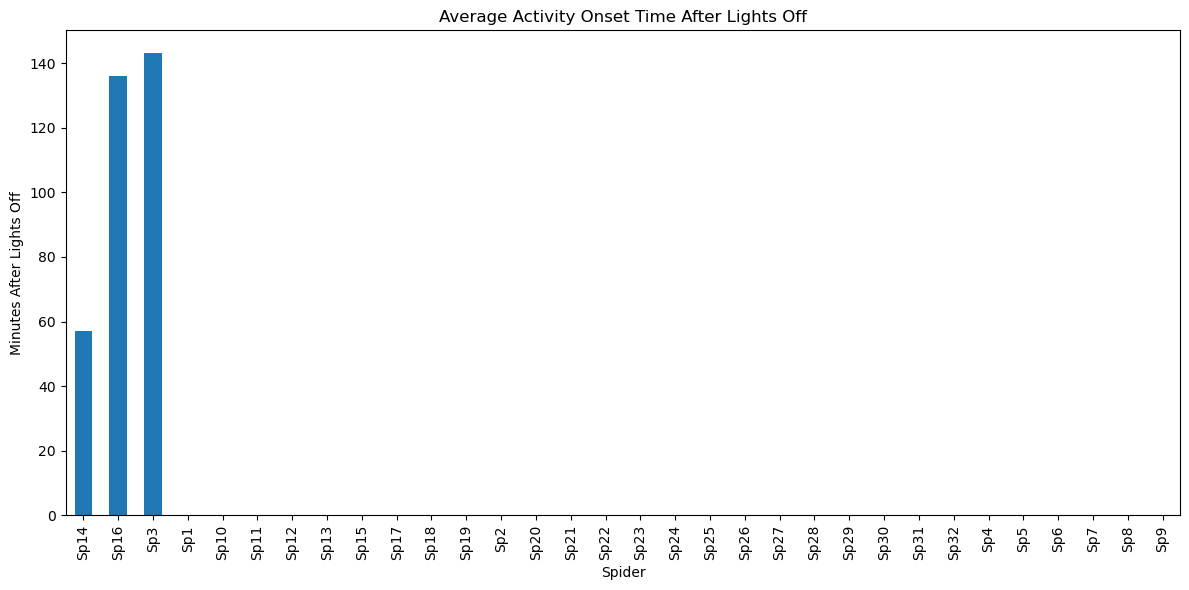

count      3.000000
mean     112.000000
std       47.759816
min       57.000000
25%       96.500000
50%      136.000000
75%      139.500000
max      143.000000
Name: Onset, dtype: float64

Spiders with early onset:
Spider
Sp14    57.0
Name: Onset, dtype: float64

Spiders with late onset:
Series([], Name: Onset, dtype: float64)


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the data
df = dataframes['df1']
df['Time'] = pd.to_datetime(df['Time'])

# Identify light-off times
light_off_times = {}
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off = day_data.loc[day_data['Light'].diff().ne(0) & (day_data['Light'] == 0), 'Time']
    if not light_off.empty:
        light_off_times[day] = light_off.iloc[0]
    else:
        print(f"Warning: No light-off time found for Day {day}")

# Function to find activity onset
def find_activity_onset(activity_data, light_off_time, window_size=60, threshold=2):
    if pd.isnull(light_off_time):
        return np.nan
    post_light_off = activity_data[activity_data.index > light_off_time].iloc[:180]
    if post_light_off.empty:
        return np.nan
    rolling_mean = post_light_off.rolling(window=window_size, center=True).mean()
    peaks, _ = find_peaks(rolling_mean, height=rolling_mean.mean() + threshold*rolling_mean.std())
    
    if len(peaks) > 0:
        onset_time = post_light_off.index[peaks[0]]
        return (onset_time - light_off_time).total_seconds() / 60
    else:
        return np.nan

# Analyze data for each spider
results = []
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off_time = light_off_times.get(day, pd.NaT)
    
    for spider in range(1, 33):  # Spiders are numbered 1 to 32
        spider_data = day_data.set_index('Time')[f'Sp{spider}']
        onset = find_activity_onset(spider_data, light_off_time)
        results.append({'Day': day, 'Spider': f'Sp{spider}', 'Onset': onset})

results_df = pd.DataFrame(results)

# Calculate average onset for each spider
average_onsets = results_df.groupby('Spider')['Onset'].mean().sort_values()

# Visualize results
plt.figure(figsize=(12, 6))
average_onsets.plot(kind='bar')
plt.title('Average Activity Onset Time After Lights Off')
plt.xlabel('Spider')
plt.ylabel('Minutes After Lights Off')
plt.tight_layout()
plt.show()

# Print summary statistics
print(average_onsets.describe())

# Identify spiders with early and late onsets
early_onset = average_onsets[average_onsets < average_onsets.mean() - average_onsets.std()]
late_onset = average_onsets[average_onsets > average_onsets.mean() + average_onsets.std()]

print("\nSpiders with early onset:")
print(early_onset)
print("\nSpiders with late onset:")
print(late_onset)

In [56]:
# Look one hour before and one hour after 
df = dataframes["df1"]
hours = df['Time'].dt.time
#df.loc[df['Time'].dt.time > time(12,00)] 

hour_before = df.loc[df['Time'].dt.time > time(6,58)] & df.loc[df['Time'].dt.time < time(7,58)]
hour_before
#dfa = df3.iloc[5142:6583] 


# Do a T test and see if there's a difference



###### What if the spider starts moving like 3 hrs later constantly? she's also entrained right 


TypeError: unsupported operand type(s) for &: 'DatetimeArray' and 'DatetimeArray'

In [106]:
import pandas as pd
from datetime import time

df = dataframes["df1"]

df['Time'] = pd.to_datetime(df['Time'])

specific_time = time(7, 58)  # 7:58 AM

hour_before = df[(df['Time'].dt.time >= (specific_time.replace(hour=specific_time.hour - 1))) & 
                 (df['Time'].dt.time < specific_time)]

hour_after = df[(df['Time'].dt.time > specific_time) & 
                (df['Time'].dt.time <= (specific_time.replace(hour=specific_time.hour + 1)))]

result = pd.concat([hour_before, hour_after])

if 'Light2' in result.columns:
    result = result.drop(columns='Light2')

display(result)

result_melted = result.melt(id_vars=['Day', 'Time', 'Light'], 
                            var_name='Spider', 
                            value_name='Activity')

result_melted["Hours"] = result_melted['Time'].dt.time

display(result_melted)

n_by_state = result_melted.groupby(["Spider", "Hours"])["Activity"].mean().reset_index()

display(n_by_state)

col_one_list = n_by_state['Spider']['Sp1']


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1195,2,2024-03-21 06:58:00,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
1196,2,2024-03-21 06:59:00,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
1197,2,2024-03-21 07:00:00,0,0,0,0,0,0,0,0,...,0,0,12,0,0,0,0,0,0,0
1198,2,2024-03-21 07:01:00,0,0,0,0,0,0,0,0,...,0,0,10,0,0,0,0,0,0,0
1199,2,2024-03-21 07:02:00,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,8,2024-03-27 08:54:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9952,8,2024-03-27 08:55:00,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9953,8,2024-03-27 08:56:00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Day,Time,Light,Spider,Activity,Hours
0,2,2024-03-21 06:58:00,0,Sp1,0,06:58:00
1,2,2024-03-21 06:59:00,0,Sp1,0,06:59:00
2,2,2024-03-21 07:00:00,0,Sp1,0,07:00:00
3,2,2024-03-21 07:01:00,0,Sp1,0,07:01:00
4,2,2024-03-21 07:02:00,0,Sp1,0,07:02:00
...,...,...,...,...,...,...
26875,8,2024-03-27 08:54:00,1,Sp32,0,08:54:00
26876,8,2024-03-27 08:55:00,1,Sp32,0,08:55:00
26877,8,2024-03-27 08:56:00,1,Sp32,0,08:56:00
26878,8,2024-03-27 08:57:00,1,Sp32,0,08:57:00


,Spider,Hours,Activity
0,Sp1,06:58:00,0.000000
1,Sp1,06:59:00,0.000000
2,Sp1,07:00:00,0.000000
3,Sp1,07:01:00,0.000000
4,Sp1,07:02:00,0.000000
...,...,...,...
3835,Sp9,08:54:00,0.000000
3836,Sp9,08:55:00,0.428571
3837,Sp9,08:56:00,0.000000
3838,Sp9,08:57:00,0.000000


KeyError: 'Sp1'

/tmp/ipykernel_197/998186995.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_avg.index = pd.to_datetime(df_avg.index.astype(str))


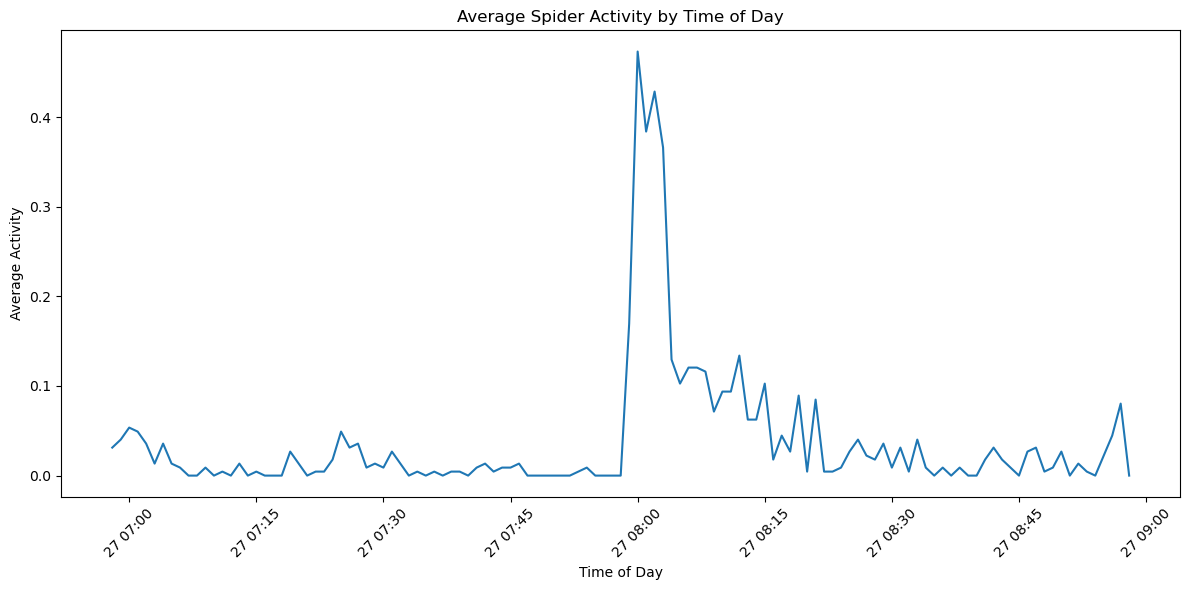

                     Sp1  Sp2       Sp3  Sp4  Sp5  Sp6  Sp7  Sp8       Sp9  \
TimeOfDay                                                                    
2024-06-27 06:58:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 06:59:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 07:00:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 07:01:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 07:02:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
...                  ...  ...       ...  ...  ...  ...  ...  ...       ...   
2024-06-27 08:54:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 08:55:00  0.0  0.0  0.285714  0.0  0.0  0.0  0.0  0.0  0.428571   
2024-06-27 08:56:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 08:57:00  0.0  0.0  2.142857  0.0  0.0  0.0  0.0  0.0  0.000000   
2024-06-27 08:58:00  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'dataframes' is a dictionary containing your dataframes
df = dataframes["df1"]

# Ensure 'Time' column is in datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Extract time (without date) and create a new column
df['TimeOfDay'] = df['Time'].dt.time

# Define the time range you're interested in
start_time = pd.to_datetime('06:58:00').time()
end_time = pd.to_datetime('08:58:00').time()

# Filter the dataframe for the specified time range
df_filtered = df[(df['TimeOfDay'] >= start_time) & (df['TimeOfDay'] <= end_time)]

# Group by TimeOfDay and calculate mean for all spider columns
spider_columns = [col for col in df.columns if col.startswith('Sp')]
df_avg = df_filtered.groupby('TimeOfDay')[spider_columns].mean()

# Calculate the overall average activity across all spiders
df_avg['AvgActivity'] = df_avg[spider_columns].mean(axis=1)

# Convert index to datetime for proper plotting
df_avg.index = pd.to_datetime(df_avg.index.astype(str)) 

# Plot the average activity
plt.figure(figsize=(12, 6))
plt.plot(df_avg.index, df_avg['AvgActivity'])
plt.title('Average Spider Activity by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the result
print(df_avg)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = dataframes["df1"]

df['Time'] = pd.to_datetime(df['Time'])

df['TimeOfDay'] = df['Time'].dt.time

start_time = pd.to_datetime('06:58:00').time()
end_time = pd.to_datetime('08:58:00').time()

df_filtered = df[(df['TimeOfDay'] >= start_time) & (df['TimeOfDay'] <= end_time)]

spider_columns = [col for col in df.columns if col.startswith('Sp')]
df_avg = df_filtered.groupby('TimeOfDay')[spider_columns].mean()

df_avg['AvgActivity'] = df_avg[spider_columns].mean(axis=1)

df_avg.index = pd.to_datetime(df_avg.index.astype(str))

plt.figure(figsize=(12, 6))
plt.plot(df_avg.index, df_avg['AvgActivity'])
plt.title('Average Spider Activity by Time of Day (Days 21-27)')
plt.xlabel('Time of Day')
plt.ylabel('Average Activity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(df_avg)

for spider in spider_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_avg.index, df_avg[spider])
    plt.title(f'Average Activity for {spider} by Time of Day (Days 21-27)')
    plt.xlabel('Time of Day')
    plt.ylabel('Average Activity')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [38]:
#AVERAGING ACTIVITY BEFORE AND AFTER

start_time = pd.to_datetime('06:58:00').time()
lightsoff_time = pd.to_datetime('07:58:00').time()
end_time = pd.to_datetime('08:58:00').time()

before_time = df_avg[(df_avg.index >= start_time) & (df_avg.index <= lightsoff_time)]
after_time = df_avg[(df_avg.index >= lightsoff_time) & (df_avg.index <= end_time)]

activity_before = before_time['AvgActivity'].mean()
activity_after = activity_before['AvgActivity'].mean()
display(before_time)

display(after_time)

#PERFORMING T-TEST


,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp8,Sp9,Sp10,...,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32,AvgActivity
TimeOfDay,,,,,,,,,,,,,,,,,,,,,
06:58:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250
06:59:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040179
07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053571
07:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049107
07:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07:54:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008929
07:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
07:56:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp8,Sp9,Sp10,...,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32,AvgActivity
TimeOfDay,,,,,,,,,,,,,,,,,,,,,
07:58:00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
07:59:00,0.0,0.0,0.428571,0.000000,0.0,0.0,0.0,0.0,0.571429,0.428571,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169643
08:00:00,0.0,0.0,2.142857,0.142857,0.0,0.0,0.0,0.0,1.857143,0.285714,...,0.0,1.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.473214
08:01:00,0.0,0.0,3.000000,0.428571,0.0,0.0,0.0,0.0,3.000000,0.142857,...,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383929
08:02:00,0.0,0.0,3.000000,0.571429,0.0,0.0,0.0,0.0,3.000000,0.000000,...,0.0,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08:54:00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
08:55:00,0.0,0.0,0.285714,0.000000,0.0,0.0,0.0,0.0,0.428571,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022321
08:56:00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044643
